Bachelor thesis - Richard Borschke - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Clustering Trip Types Based On Centrality And Duration

This notebook contains the identification of trip types. Following steps are performed:
* Feature selection
* Feature scaling via MinMaxScaler
* Clustering of trip types via k-means
* Evaluation of clustering (select k)
* Interpretation and visualization of cluster results
* Distribution of identified trip types among mobility modes

### Imports

In [1]:
import pandas as pd
import glob

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_theme(style="white")

from sklearn.preprocessing import MinMaxScaler


from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

import time
# import numpy as np

### Load Data

In [2]:
# load monthly data of mode based on selected months
def load_data(mode, months):
    first_read = True
    
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Modes/data_supplemented_{}_{}.csv'.format(mode, month))], ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    
    return data_full

# load full data of mode
def load_data_mode_full(mode):
    data_mode_full = pd.read_csv('Data/Modes/data_supplemented_full_{}.csv'.format(mode))
    
    return data_mode_full

In [3]:
# define months for data loading (YYYYMM)
months = ['201911', '201912', '202001', '202002']

#load data by months
load_monthly_data = False

if (load_monthly_data):
    data_car = load_data('car', months)
    data_bicycle = load_data('bicycle', months)
    data_scooter = load_data('scooter', months)
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

In [4]:
# read in desired data
# set True if full data set load is desired
load_full_data = True

if (load_full_data):
    data_car = load_data_mode_full('car')
    data_bicycle = load_data_mode_full('bicycle')
    data_scooter = load_data_mode_full('scooter')
    data_full = pd.concat([data_car, data_bicycle, data_scooter], ignore_index=True)

### Feature selection

In [5]:
# select only dist features (based on manuelly defined trip types in literature) and id + vehicleType for later interpretation

dfa = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration']].copy()
df = dfa.sample(n=30000, random_state=1)

#df = data_full[['id','vehicleType','dist_center_start','dist_center_end', 'duration']].copy()

df['duration'] = df['duration'] / 60
df.columns

Index(['id', 'vehicleType', 'dist_center_start', 'dist_center_end',
       'duration'],
      dtype='object')

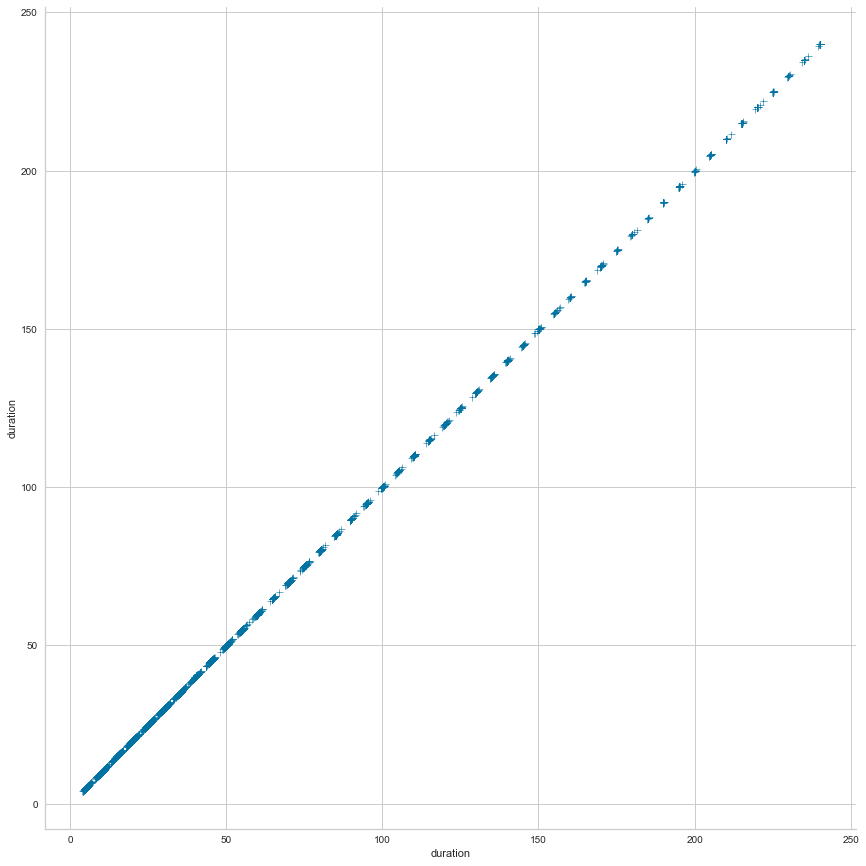

In [6]:
# plot features to visually observe structure of data
g = sns.relplot(x="duration", y="duration", kind="scatter", data=df, marker='+', height=12, aspect=1)

In [7]:
df['duration'].max()

240.0

In [8]:
from scipy.stats import zscore
import numpy as np

# remove extreme outliers
# data values that have a z-score sigma greater than a threshold of 4, are declared to be outliers.
z_scores = zscore(df[['dist_center_start','dist_center_end','duration']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4).all(axis=1)
df = df[filtered_entries]
df


#df = df[(df['dist_center_start']<11000)&(df['dist_center_end']<11000)]

# plot indicates four interpretable convex clusters
#g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=12, aspect=1)




,id,vehicleType,dist_center_start,dist_center_end,duration
120814,ZnJlZWZsb2F0OjpjYXIyZ286OldEQzE1Njk0MjFKNjEyMjMw,car,1986,3290,20.000000
60088,ZnJlZWZsb2F0OjpjYXIyZ286OldERDE3NzA0NDFKMTEwOTcz,car,4756,1625,50.016667
46984,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzMDI4,car,4353,525,40.000000
146684,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLNDA4MzE1,car,2169,2844,30.000000
198253,ZnJlZWZsb2F0OjpjYXIyZ286OldNV1hSMTEwMDBURTU3ODA0,car,1586,2935,25.033333
...,...,...,...,...,...
71725,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjczNjUw,car,1384,1149,64.716667
373590,YmlrZTo6dGllcjo6ZmZiNjJlZDctZjBiMi00OGMxLWE2NT...,scooter,4465,4396,9.966667
330644,YmlrZTo6dGllcjo6ZWQwNDdiMWQtZGQxYy00MTgzLTlhZm...,scooter,3646,571,25.016667
202888,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzg0NTA5,car,1970,3675,50.016667


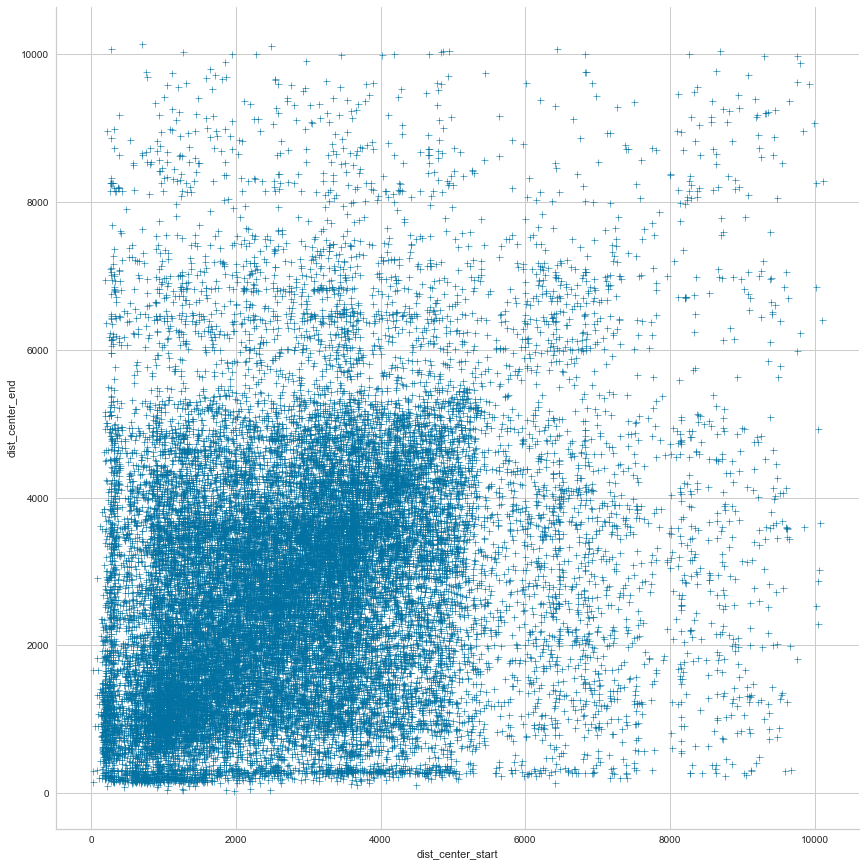

In [9]:
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=df, marker='+', height=12, aspect=1)

### Feature scaling

(array([0, 1, 2]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration')])

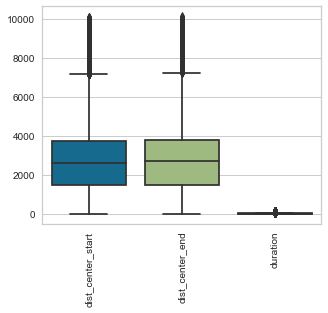

In [10]:
# look at feature skewness
plt.figure(figsize=(5,4))
sns.boxplot(data=df)
plt.xticks(rotation=90)

In [11]:
df_minmax = df[['dist_center_start','dist_center_end', 'duration']].copy()

# save names
names = df_minmax.columns

# scale data
scaler = MinMaxScaler()
scaler.fit(df_minmax)
df_minmax = scaler.transform(df_minmax)

# convert scaled array into dataframe
scaled_df = pd.DataFrame(df_minmax, columns=names) 

scaled_df

,dist_center_start,dist_center_end,duration
0,0.194549,0.323046,0.114077
1,0.469078,0.158358,0.325885
2,0.429138,0.049555,0.255204
3,0.212686,0.278932,0.184641
4,0.154906,0.287933,0.149594
...,...,...,...
29394,0.134886,0.111276,0.429613
29395,0.440238,0.432443,0.043279
29396,0.359068,0.054105,0.149477
29397,0.192963,0.361128,0.325885


(array([0, 1, 2]),
 [Text(0, 0, 'dist_center_start'),
  Text(1, 0, 'dist_center_end'),
  Text(2, 0, 'duration')])

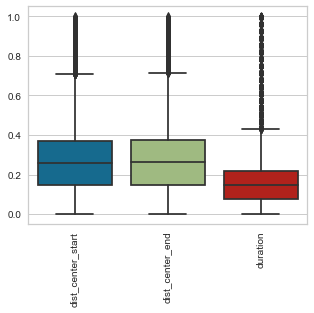

In [12]:
# visualize scaled features (still right skewed but scaled from 0 to 1 + 0 remains)
plt.figure(figsize=(5,4))
sns.boxplot(data=scaled_df)
plt.xticks(rotation=90)

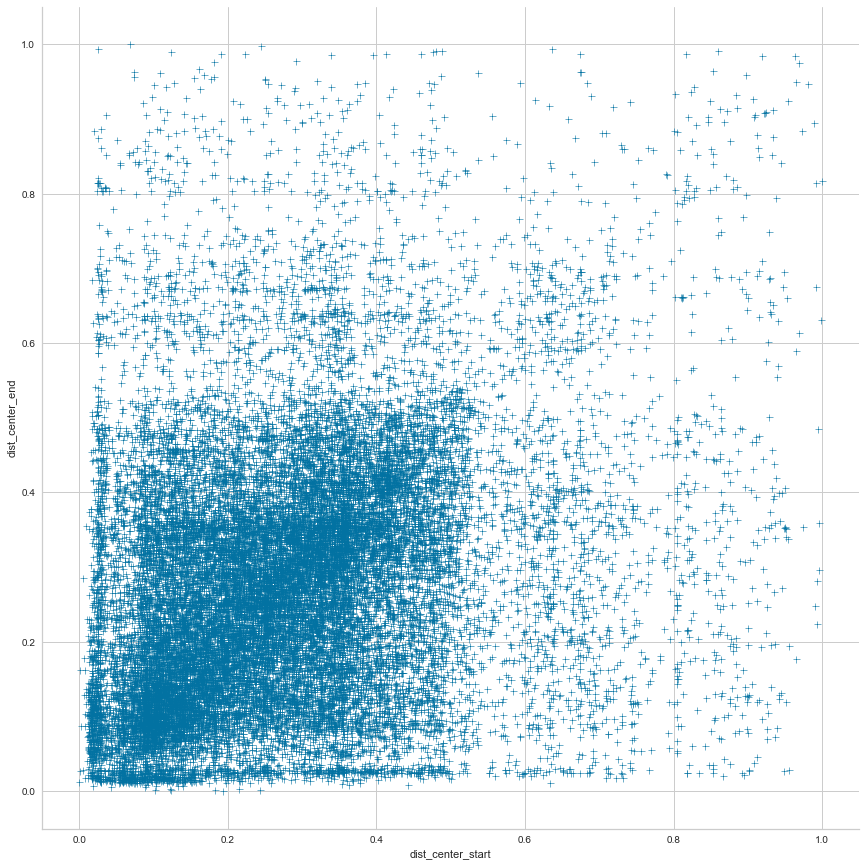

In [13]:
# plot still indicates four interpretable convex clusters
g = sns.relplot(x="dist_center_start", y="dist_center_end", kind="scatter", data=scaled_df, marker='+', height=12, aspect=1)

### Cluster Tendency

In [14]:
from pyclustertend import hopkins
hopkins(scaled_df, 10000)

0.13739557803025046

### Clustering trip types via k-means and parameter selection

In [15]:
# run k-means multiple times to identify "optimal" k
from sklearn import metrics
from sklearn.metrics import silhouette_score

# with-in cluster sum of squares
wcss=[]

# silhouette coefficients
silhouette_coefficients = []

# run loop
for i in range (2,15):   
    start = time.time()
    kmeans = KMeans(i)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)
    print(kmeans.inertia_)
    
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_coefficients.append(score)
    print(score)
    
    end = time.time()
    print(i)
    print(end - start)

1635.138172310571
0.31822901626593136
2
19.137012243270874
1316.923931291154
0.3144793899252345
3
21.11696743965149
1085.2904542983295
0.30089032533121757
4
20.999476194381714
916.9367865352548
0.28868646187076996
5
22.294668197631836
796.4418087642674
0.3049445706523691
6
17.891643047332764
693.8534687568928
0.31166754623201937
7
17.020430088043213
631.3525144171479
0.3136263662687433
8
16.95585060119629
575.5510680797681
0.29693812881398607
9
19.05972146987915
528.287896150456
0.29898678654897837
10
18.647417068481445
493.7412769955294
0.30206369826553664
11
18.138003826141357
470.3135126600015
0.26416972342476475
12
16.545828819274902
447.68512059848183
0.2673018786347933
13
17.14552664756775
429.6751266098218
0.26473210846515927
14
17.731660842895508


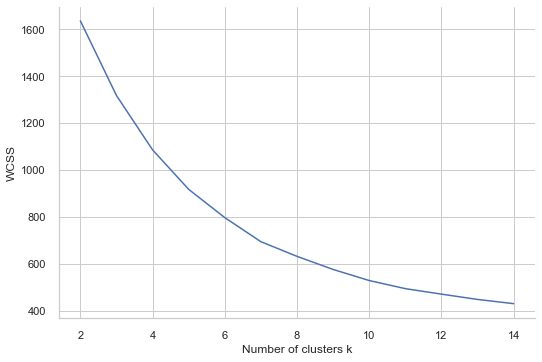

In [16]:
# plot elbow plot to visually pick "optimal" k
sns.set_theme(style="whitegrid")
g = sns.relplot(x=range(2,15), y=wcss, kind="line", height=5, aspect=1.5)
g.set_axis_labels('Number of clusters k', 'WCSS')

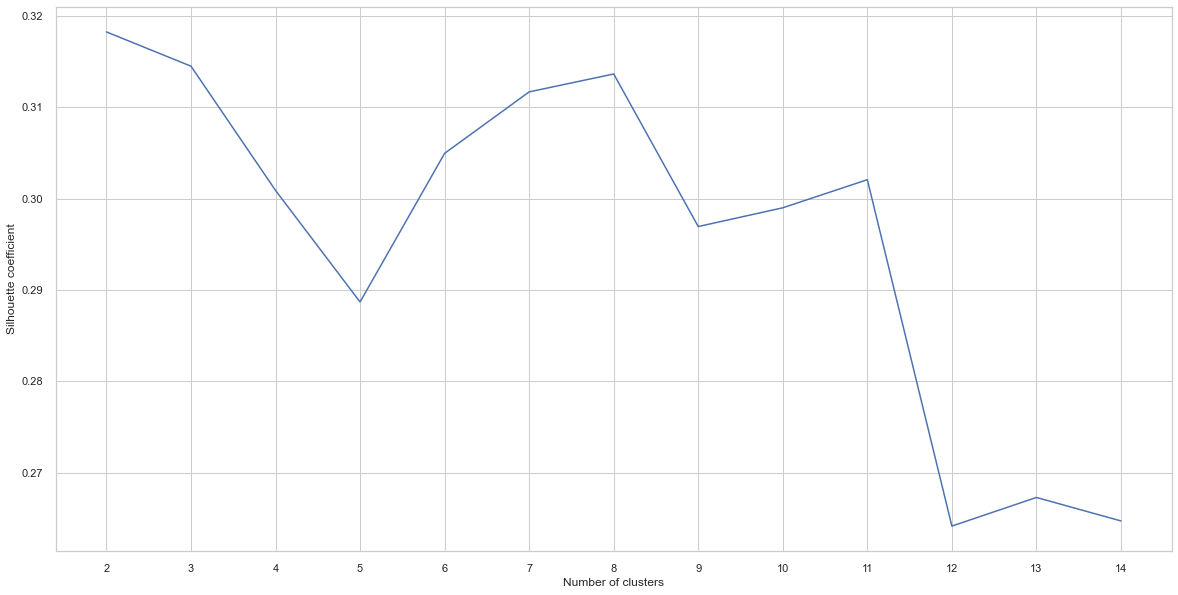

In [18]:
# plot silhouette coefficients for each k
plt.figure(figsize=(20, 10))
plt.plot(range(2, 15), silhouette_coefficients)
plt.xticks(range(2, 15))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette coefficient")
plt.show()

# silhouette score EXTREMELY high running time
if (False):
    model = KMeans(random_state=0)

    # select range of cluster number and the metric to observe costs
    visualizer = KElbowVisualizer(model, k=(2,15), metric='silhouette', timings=False)

    # fit and visualize
    visualizer.fit(scaled_df)    
    visualizer.poof()

In [36]:
# cluster data for the chosen number of clusters
k = 8
k_means_new = KMeans(k)

kmeans.fit(scaled_df)

clustered_data = df.copy()
clustered_data['cluster'] = k_means_new.fit_predict(scaled_df)

clustered_data

,id,vehicleType,dist_center_start,dist_center_end,duration,cluster
120814,ZnJlZWZsb2F0OjpjYXIyZ286OldEQzE1Njk0MjFKNjEyMjMw,car,1986,3290,20.000000,5
60088,ZnJlZWZsb2F0OjpjYXIyZ286OldERDE3NzA0NDFKMTEwOTcz,car,4756,1625,50.016667,4
46984,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjkzMDI4,car,4353,525,40.000000,4
146684,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLNDA4MzE1,car,2169,2844,30.000000,5
198253,ZnJlZWZsb2F0OjpjYXIyZ286OldNV1hSMTEwMDBURTU3ODA0,car,1586,2935,25.033333,5
...,...,...,...,...,...,...
71725,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMjczNjUw,car,1384,1149,64.716667,6
373590,YmlrZTo6dGllcjo6ZmZiNjJlZDctZjBiMi00OGMxLWE2NT...,scooter,4465,4396,9.966667,1
330644,YmlrZTo6dGllcjo6ZWQwNDdiMWQtZGQxYy00MTgzLTlhZm...,scooter,3646,571,25.016667,4
202888,ZnJlZWZsb2F0OjpjYXIyZ286OldNRTQ1MzM0MjFLMzg0NTA5,car,1970,3675,50.016667,5


### Interpretation and visualization of results

* cluster: inner-inner trips
* cluster: outer-outer trips
* cluster: outer-inner trips
* cluster: inner-outer trips

In [37]:
# show cluster results for interpretation
clustered_data.groupby(['cluster']).mean()

,dist_center_start,dist_center_end,duration
cluster,,,
0,1355.420085,1351.754395,14.779608
1,3716.699774,3724.029496,19.377106
2,2513.508701,6684.039491,38.801294
3,6837.042523,2588.683912,40.645901
4,3480.549622,1557.817914,31.582443
5,1614.108487,3472.708141,28.679013
6,2958.546481,2876.889774,92.950952
7,6508.222732,6519.413318,28.260505


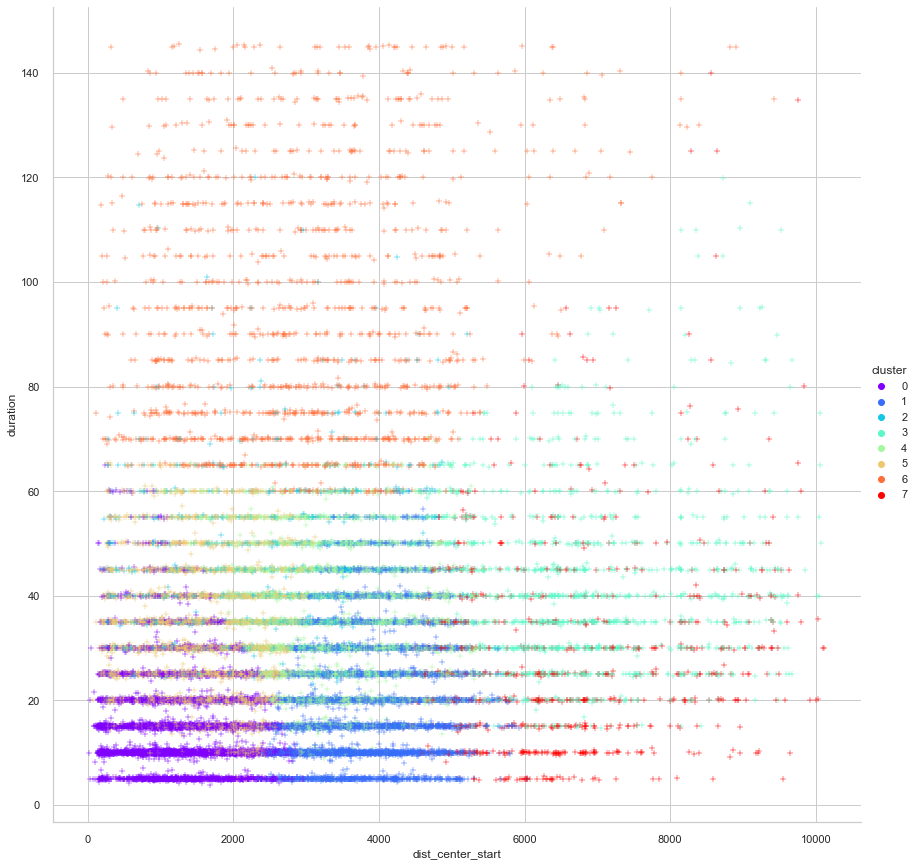

In [38]:
# plot cluster results
g = sns.relplot(x="dist_center_start", y="duration", kind="scatter", data=clustered_data, legend='full', marker='+', hue='cluster', palette='rainbow', height=12, aspect=1)
#sns.pairplot(clustered_data, hue="cluster", plot_kws=dict(marker="+", linewidth=1), palette='rainbow')

### Distribution of trip types among mobility modes

In [30]:
# show cluster distribution
clustered_data.groupby(['vehicleType','cluster']).describe()

dist_center_start                                    \
                                count         mean          std     min   
vehicleType cluster                                                       
bicycle     0                     9.0  6077.777778   260.544995  5789.0   
            1                   458.0  3362.397380   579.519317  2399.0   
            2                   343.0  1718.119534   669.060680   116.0   
            3                    10.0  2793.800000  1082.637602   784.0   
            4                   106.0  2281.141509  1001.281935   262.0   
            5                     5.0  6069.200000  1841.582662  4745.0   
            6                   309.0  3123.747573   574.658929  1066.0   
            7                   689.0  1467.590711   663.886978    30.0   
car         0                  1373.0  6856.172615  1220.415366  4544.0   
            1                  3508.0  3832.977480   700.898564  2333.0   
            2                  3893.0  1591.375546   693.688026   193.0   
            3                  1406.0  2494.643670  1162.288870   193.0   
            4                  1297.0  3102.183500  1465.102937   190.0   
            5                   761.0  6560.165572  1450.207670  4328.0   
            6                  3896.0  3543.226643   807.669752  1045.0   
            7                  1500.0  1470.380667   636.064414   140.0   
scooter     0                    27.0  6136.259259   392.258215  5438.0   
            1                  2745.0  3576.203279   687.746015  2244.0   
            2                   853.0  1625.255569   608.742777    79.0   
            3                    55.0  2784.127273   963.096935   635.0   
            4                    97.0  1879.577320  1186.300015   116.0   
            5                   140.0  5912.450000   686.555392  4440.0   
            6                   506.0  3268.988142   600.629185   922.0   
            7                  5413.0  1316.392019   655.341476    23.0   

                                                       dist_center_end  \
                         25%     50%      75%      max           count   
vehicleType cluster                                                      
bicycle     0        5827.00  6074.0  6367.00   6417.0             9.0   
            1        2904.75  3302.0  3691.75   5207.0           458.0   
            2        1214.50  1863.0  2256.00   3124.0           343.0   
            3        1898.25  3371.0  3610.75   3704.0            10.0   
            4        1415.50  2361.0  3100.50   4239.0           106.0   
            5        4957.00  5276.0  6146.00   9222.0             5.0   
            6        2670.00  3148.0  3565.00   4668.0           309.0   
            7        1019.00  1445.0  1994.00   2883.0           689.0   
car         0        6036.00  6697.0  7546.00  10076.0          1373.0   
            1        3288.75  3730.5  4369.00   5874.0          3508.0   
            2        1071.00  1603.0  2148.00   3372.0          3893.0   
            3        1565.25  2584.0  3436.00   5209.0          1406.0   
            4        2001.00  3111.0  4097.00   9428.0          1297.0   
            5        5263.00  6388.0  7516.00  10113.0           761.0   
            6        2951.75  3498.0  4129.25   5806.0          3896.0   
            7         976.00  1494.0  1984.00   2970.0          1500.0   
scooter     0        5846.50  6059.0  6475.50   6896.0            27.0   
            1        3035.00  3508.0  4075.00   6030.0          2745.0   
            2        1189.00  1736.0  2156.00   2713.0           853.0   
            3        2193.00  2968.0  3498.50   4431.0            55.0   
            4         967.00  1578.0  2571.00   5125.0            97.0   
            5        5377.50  5986.5  6375.25   7846.0           140.0   
            6        2922.25  3207.5  3591.75   5325.0           506.0   
            7         862.00  1247.0  1783.00   2966.0          5413.0

In [31]:
def create_distribution_overview(mode):
    
    distribution = clustered_data[clustered_data['vehicleType']==mode]

    distribution = distribution.groupby(['cluster']).count().copy()
    trip_volume = len(clustered_data[clustered_data['vehicleType']==mode])
    distribution['Distribution [%]'] = distribution['id'] / trip_volume *100

    return distribution[['Distribution [%]']]

In [32]:
create_distribution_overview('car')

,Distribution [%]
cluster,
0,7.786095
1,19.893388
2,22.076670
3,7.973234
4,7.355109
5,4.315527
6,22.093683
7,8.506295


In [33]:
create_distribution_overview('bicycle')

,Distribution [%]
cluster,
0,0.466563
1,23.742872
2,17.781234
3,0.518403
4,5.495075
5,0.259202
6,16.018663
7,35.717989


In [34]:
create_distribution_overview('scooter')

,Distribution [%]
cluster,
0,0.274502
1,27.907686
2,8.672224
3,0.559170
4,0.986173
5,1.423343
6,5.144368
7,55.032534
